In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lifelines -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
TRAIN_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/Select_K_Best_features_train_new.csv"
TEST_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/Select_K_Best_features_test_new.csv"

#TRAIN_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/20feature_csv/Select_K_Best_features_train.csv"
#TEST_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/20feature_csv/Select_K_Best_features_test.csv"

#TRAIN_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/40feature_csv/Select_K_Best_features_train.csv"
#TEST_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/40feature_csv/Select_K_Best_features_test.csv"

In [ ]:
import pandas as pd
# load the training data
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

,ABHD1,AMY2A,ARL5B,ASMTL,BMS1P1,FRA10AC1,CCDC7,PEAK3,CCNJ,CD81,...,UNC93B1,ZBTB6,ZNF22,ZNF248,FLJ23404,ZNF510,ZNF676,ZNF98,Disease Free (Months),DFS_STATUS_ENCODED
0,0.5427,0.0042,-1.3015,0.0727,-0.8790,-0.2001,-2.4443,0.5504,-0.3501,1.3306,...,0.3042,-0.3621,-0.7499,-1.2925,-0.3176,-0.0527,-1.1132,-0.3769,8.41,1.0
1,1.0479,-1.6920,-0.2573,-1.1518,-0.2721,0.5470,-1.0024,0.4532,-0.0342,-0.3876,...,0.4726,-0.8513,-1.4436,0.4544,0.5857,-0.7763,-0.5119,-0.1707,2.56,1.0
2,-0.3481,-0.0009,-0.1168,-1.4332,0.8405,-0.7239,-0.2558,-0.1502,0.9477,-0.2253,...,0.5460,-0.3803,0.0617,-0.0401,0.2981,0.5104,-0.5328,-0.5964,1.22,0.0
3,0.8966,-0.7667,-0.7190,0.7776,0.4796,0.0019,0.3988,0.9589,-0.8363,-0.1055,...,0.9282,-0.1266,-0.8905,-0.2346,0.3443,0.2540,-0.7956,-1.2834,13.40,1.0
4,0.5154,-1.6920,1.1848,0.4461,0.5990,1.4794,-0.4612,-0.4449,1.6616,-1.3079,...,-0.2614,-0.5663,0.2724,1.1534,1.3512,0.4122,-0.8140,-0.9292,3.19,1.0


In [ ]:
#Drop cols based on convergence

columns_to_drop = ['KRTAP9-4', 'OR2T2', 'OR4F17', 'SNORA36B']
train_data.drop(columns_to_drop, axis=1, inplace = True)

Cross-validation

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import numpy as np
def apply_cross_validation(df:pd.DataFrame, penalty: float = 1) -> None:
    # create the folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    c_index_scores = []
    # run cross validation
    for train_index, val_index in kf.split(train_data):
        train_fold = df.iloc[train_index]
        val_fold = df.iloc[val_index]
        cph = CoxPHFitter(penalizer = penalty)
        cph.fit(train_fold, duration_col='Disease Free (Months)', event_col='DFS_STATUS_ENCODED')
        val_predictions = cph.predict_partial_hazard(val_fold)
        c_index = concordance_index(val_fold['Disease Free (Months)'], -val_predictions, val_fold['DFS_STATUS_ENCODED'])
        c_index_scores.append(c_index)
    print(f"Average Validation C-index: {np.mean(c_index_scores)}")

In [ ]:
apply_cross_validation(train_data, penalty = 1)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['MYF5'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


Average Validation C-index: 0.74395797056143


Train the model on the entire training set with the best parameter

In [ ]:
# Train the final model on the entire training set
cph_final = CoxPHFitter(penalizer = 0.1)
# fit on train data
cph_final.fit(train_data, duration_col='Disease Free (Months)', event_col='DFS_STATUS_ENCODED')
cph_final.print_summary()
# Concordance Index
c_index = cph_final.concordance_index_
print(f"Concordance Index: {c_index}")

<lifelines.CoxPHFitter: fitted with 73 total observations, 17 right-censored observations>
             duration col = 'Disease Free (Months)'
                event col = 'DFS_STATUS_ENCODED'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 73
number of events observed = 56
   partial log-likelihood = -154.02
         time fit was run = 2024-12-30 02:23:19 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
ABHD1         -0.19      0.83      0.24           -0.67            0.29                0.51                1.33
AMY2A         -0.43      0.65      0.23           -0.87            0.02                0.42                1.02
ARL5B          0.03      1.03      0.22           -0.41            0.47                0.66                1.60
ASMTL          0.22      1.24      0.22           -0.22            0.65                0.81                1.91
BMS1P1         0.22      1.25      0.24           -0.25            0.69                0.78                1.99
FRA10AC1       0.11      1.12      0.25           -0.37            0.60                0.69                1.83
CCDC7         -0.25      0.78      0.16           -0.55            0.06                0.57                1.06
PEAK3         -0.09      0.92      0.23           -0.54            0.37                0.58                1.44
CCNJ           0.33      1.39      0.26           -0.18            0.84                0.84                2.32
CD81          -0.17      0.84      0.26           -0.69            0.34                0.50                1.41
CSGALNACT2     0.22      1.24      0.25           -0.27            0.70                0.76                2.02
DNAJC30        0.56      1.76      0.23            0.12            1.01                1.13                2.74
MGC4342       -0.08      0.92      0.22           -0.52            0.36                0.59                1.43
FAM35A        -0.27      0.76      0.24           -0.74            0.20                0.48                1.22
SHLD2P3       -0.34      0.71      0.27           -0.87            0.19                0.42                1.21
FAM35BP       -0.08      0.92      0.27           -0.61            0.44                0.55                1.55
FBXO27         0.43      1.54      0.19            0.07            0.80                1.07                2.23
GLT6D1        -0.35      0.70      0.31           -0.96            0.25                0.38                1.29
LCORL         -0.41      0.66      0.25           -0.91            0.08                0.40                1.09
LGALS3BP       0.20      1.22      0.24           -0.27            0.67                0.76                1.95
MOSPD3         0.07      1.08      0.24           -0.39            0.54                0.68                1.71
MUL1          -0.53      0.59      0.24           -1.00           -0.05                0.37                0.95
MYF5          -0.01      0.99      0.09           -0.19            0.16                0.83                1.18
MYH4          -0.02      0.98      0.35           -0.70            0.67                0.49                1.95
NAGPA         -0.19      0.83      0.22           -0.63            0.24                0.54                1.27
NKX2-4        -0.07      0.93      0.22           -0.51            0.37                0.60                1.44
PATE4          0.01      1.01      0.34           -0.65            0.67                0.52                1.96
PCYT2         -0.21      0.81      0.19           -0.58            0.17                0.56                1.19
DKFZp564M1863 -0.26      0.77      0.24           -0.73            0.20                0.48                1.22
PIGT           0.52      1.68      0.20            0.12            0.92          

Concordance Index: 0.8794089609151573


Hazard ratio

In [ ]:
hazard_ratio = cph_final.hazard_ratios_
hazard_ratios_sort = hazard_ratio.sort_values()

Draw bar plot

<Axes: title={'center': 'Hazard Ratio vs. Covariate'}, xlabel='covariate', ylabel='Hazard Ratio'>

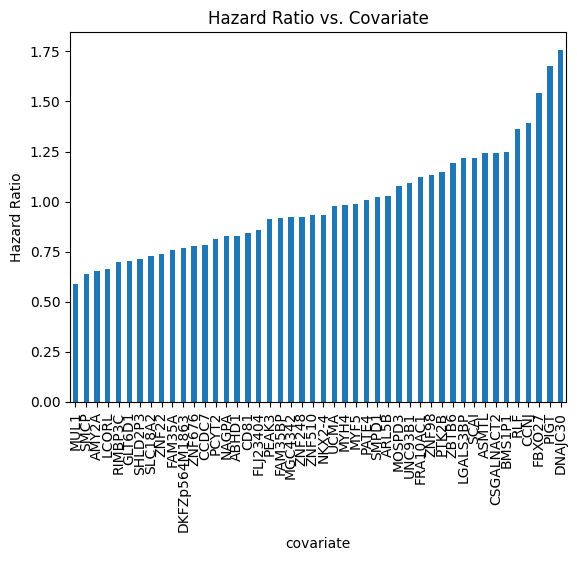

In [ ]:
hazard_ratios_sort.plot.bar(ylabel="Hazard Ratio", title="Hazard Ratio vs. Covariate")

Test data evaluation

In [ ]:
# read the test data
test_data = pd.read_csv(TEST_PATH)
print(test_data.shape)
test_data.head()

(19, 52)


,ABHD1,AMY2A,ARL5B,ASMTL,BMS1P1,FRA10AC1,CCDC7,PEAK3,CCNJ,CD81,...,UNC93B1,ZBTB6,ZNF22,ZNF248,FLJ23404,ZNF510,ZNF676,ZNF98,Disease Free (Months),DFS_STATUS_ENCODED
0,0.1206,-0.538,-0.4877,0.9252,-2.8018,-0.8582,-0.8630,1.3354,-1.3207,0.8436,...,1.9913,-0.0029,0.2942,-2.1451,-1.6352,-0.8553,-1.1132,-0.8145,13.11,1.0
1,0.0855,-1.692,-0.3291,0.4169,-0.6546,-0.9684,-1.7453,0.2720,0.0472,-2.5123,...,0.0130,1.0599,0.3499,-0.5196,-0.2263,1.1665,0.0096,0.0456,5.19,1.0
2,-3.1493,1.163,-0.0946,1.2001,0.3905,0.5494,0.3818,-0.9768,0.2387,-0.4058,...,0.2100,-0.2163,-0.3369,-0.3830,-0.0708,0.2971,-0.5737,-0.6447,9.40,0.0
3,0.0989,-1.692,0.0611,-0.0185,-1.1171,-0.9208,0.1432,-0.1606,0.3548,-0.6095,...,-0.0466,0.9623,0.6896,-0.4969,0.1592,0.3967,-0.8014,-1.2834,4.86,1.0
4,-0.6431,-1.692,1.5867,-0.0972,1.2540,0.5406,0.5078,0.8183,1.0868,-0.3580,...,-0.7015,-0.7727,0.1924,1.1109,0.9264,-0.4374,0.4539,1.4212,1.87,1.0


In [ ]:
test_risk_score = cph_final.predict_partial_hazard(test_data)
test_c_index = concordance_index(test_data['Disease Free (Months)'], -test_risk_score, test_data['DFS_STATUS_ENCODED'])
print(test_c_index)

0.6428571428571429


<Axes: title={'center': 'Risk Score vs. Individual'}, xlabel='Patient', ylabel='Risk Score'>

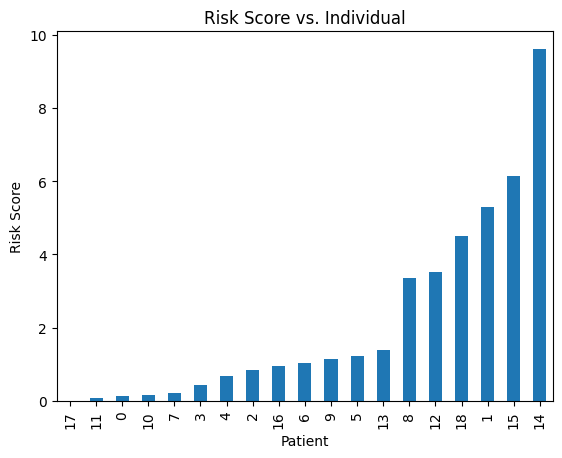

In [ ]:
sorted_risk_score = test_risk_score.sort_values()
sorted_risk_score.plot.bar(ylabel="Risk Score", xlabel="Patient", title="Risk Score vs. Individual")

Survival probabilities

In [ ]:
survival_probabilities = cph_final.predict_survival_function(test_data, times=test_data["Disease Free (Months)"].to_list())
survival_probabilities_sorted = survival_probabilities.sort_index()
survival_probabilities_sorted.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1.12,0.999097,0.968061,0.994871,0.997276,0.995789,0.992545,0.993616,0.998666,0.979649,0.992988,0.999037,0.999578,0.978685,0.991525,0.942890,0.963077,0.994233,0.999958,0.972794
1.87,0.997932,0.928289,0.988282,0.993768,0.990373,0.982992,0.985426,0.996945,0.953960,0.984000,0.997795,0.999034,0.951810,0.980679,0.873887,0.917370,0.986828,0.999903,0.938727
2.20,0.997084,0.900353,0.983510,0.991220,0.986447,0.976091,0.979503,0.995694,0.935674,0.977504,0.996890,0.998637,0.932700,0.972853,0.826826,0.885449,0.981469,0.999863,0.914666
2.37,0.995937,0.863852,0.977084,0.987779,0.981154,0.966823,0.971538,0.994001,0.911465,0.968774,0.995667,0.998100,0.907428,0.962354,0.767102,0.843979,0.974258,0.999808,0.883059
2.69,0.993732,0.797712,0.964833,0.981190,0.971046,0.949231,0.956389,0.990751,0.866619,0.952191,0.993317,0.997068,0.860699,0.942463,0.664024,0.769551,0.960528,0.999704,0.825267


In [ ]:
from tabulate import tabulate
import pandas as pd


# Print the first few rows in a tabular format
def print_survival_table_lifelines(survival_probabilities_sorted):
    # Convert the DataFrame to a list of lists for tabulate
    headers = ["Time (Months)"] + [f"Patient {i+1}" for i in range(survival_probabilities_sorted.shape[1])]
    rows = []

    # Iterate over the DataFrame and prepare rows with time and survival probabilities
    for time, row in survival_probabilities_sorted.iterrows():
        row_data = [f"{time:.2f}"] + [f"{value:.4f}" for value in row]
        rows.append(row_data)

    # Print using tabulate
    print(tabulate(rows, headers=headers, tablefmt="grid"))

# Call the function to print the table
print_survival_table_lifelines(survival_probabilities_sorted)


+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   Time (Months) |   Patient 1 |   Patient 2 |   Patient 3 |   Patient 4 |   Patient 5 |   Patient 6 |   Patient 7 |   Patient 8 |   Patient 9 |   Patient 10 |   Patient 11 |   Patient 12 |   Patient 13 |   Patient 14 |   Patient 15 |   Patient 16 |   Patient 17 |   Patient 18 |   Patient 19 |
+=================+=============+=============+=============+=============+=============+=============+=============+=============+=============+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
|            1.12 |      0.9991 |      0.9681 |      0.9949 |      0.9973 |      0.9958 |      0.9925 |      0.9

Plot survival analysis

In [ ]:
import matplotlib.colors as mcolors
import random

def generate_random_colors(n):
    # Get a list of all matplotlib color names
    color_names = list(mcolors.CSS4_COLORS.keys())
    # Check if the requested number of colors is greater than the available colors
    if n > len(color_names):
        raise ValueError(f"Requested number of colors exceeds available colors ({len(color_names)}).")
    # Select n random colors
    random_colors = random.sample(color_names, n)
    return random_colors

def generate_interpolation(id, index, intervals):
    time_occured = test_data["Disease Free (Months)"].to_list()
    intersection = np.interp(time_occured[index], intervals, survival_probabilities_sorted[id])
    return intersection

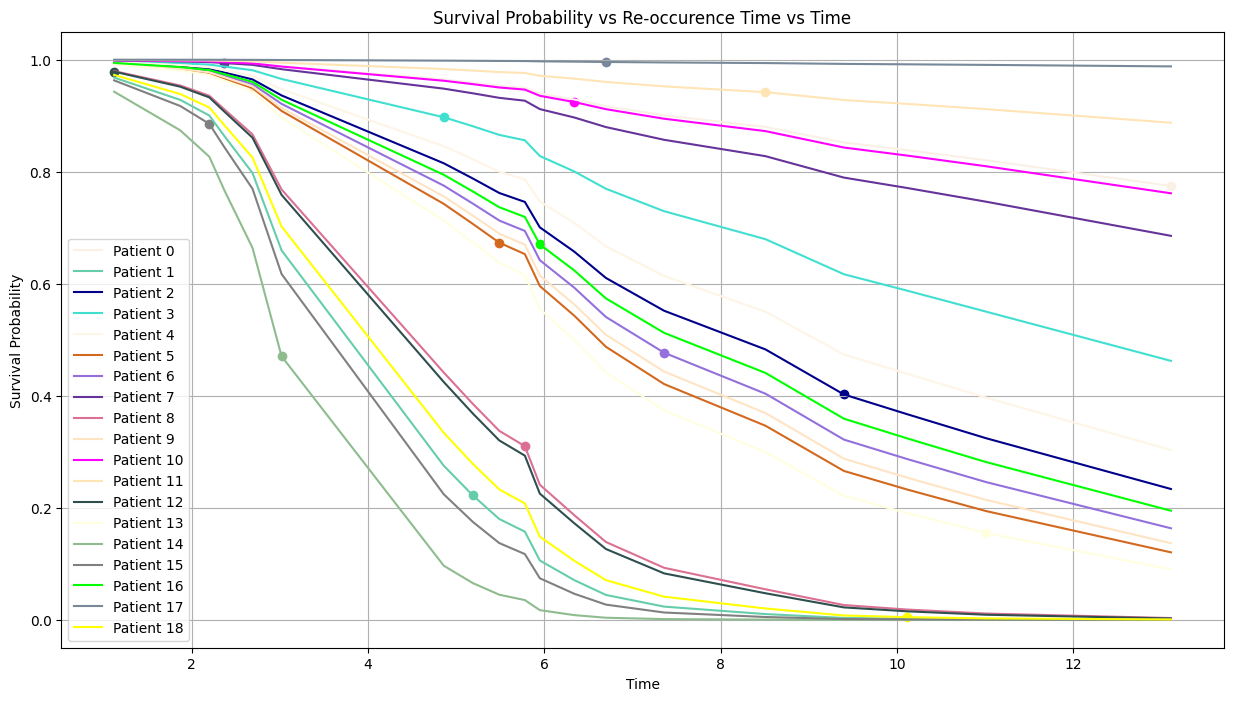

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# patients
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)
color_palatte = generate_random_colors(len(patients_id))
time_occured = test_data["Disease Free (Months)"].to_list()
plt.figure(figsize = (15,8))
for index, id in enumerate(patients_id):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(), label = f"Patient {id}", color = color_palatte[index])
    plt.scatter(x = time_occured[index], y = generate_interpolation(id, index, time_intervals), color = color_palatte[index])
plt.legend(loc = "best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel('Survival Probability')
plt.title("Survival Probability vs Re-occurence Time vs Time")
plt.show()

**Visualization of 3 random patients**

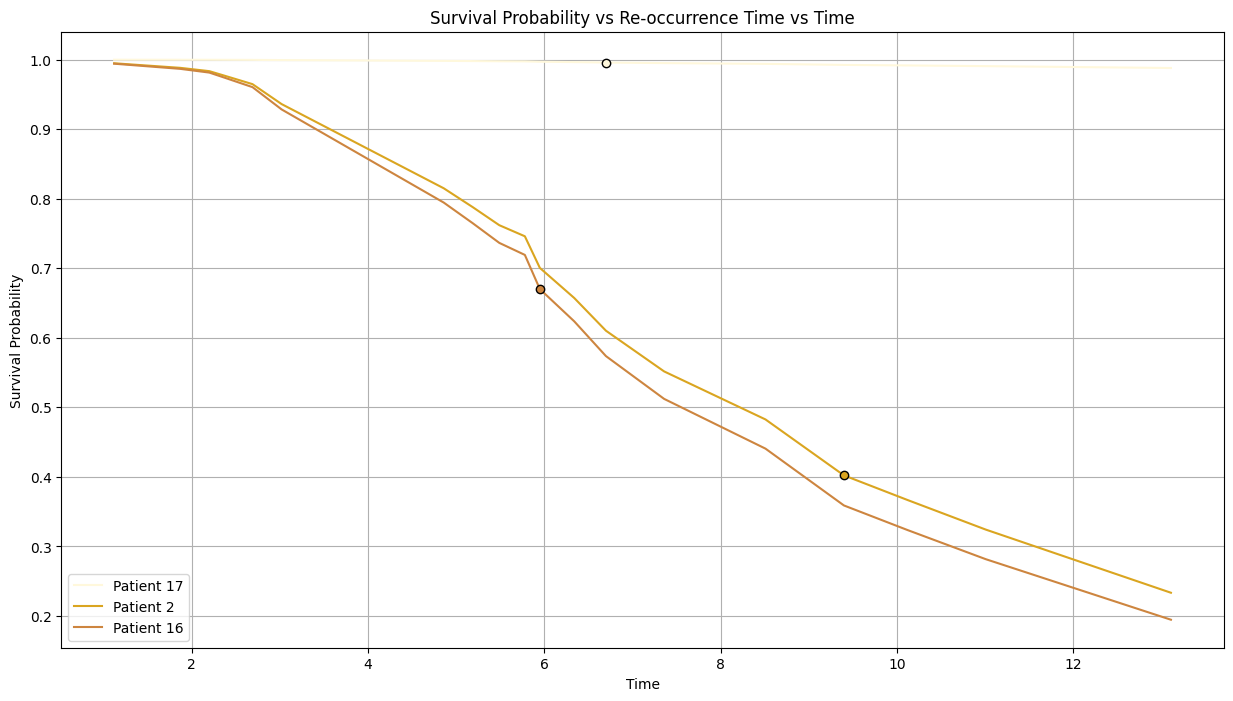

In [ ]:
# Visualization of 3 random Patients with DFS_STATUS_ENCODED = 0

# Get patient IDs and time intervals
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)

# Filter test_data for patients with DFS_STATUS_ENCODED == 0
filtered_data = test_data[test_data['DFS_STATUS_ENCODED'] == 0]
# Ensure we have at least 3 patients; otherwise, select all available patients
num_patients_to_select = min(3, len(filtered_data))
selected_patients = random.sample(list(filtered_data.index), num_patients_to_select)


# Initialize color palette for selected patients
color_palatte = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Plotting
plt.figure(figsize=(15, 8))
for index, id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(),
             label=f"Patient {id}", color=color_palatte[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(id)
    plt.scatter(x=time_occured[patient_index], y=generate_interpolation(id, patient_index, time_intervals),
                color=color_palatte[index],edgecolor='black',zorder=5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability vs Re-occurrence Time vs Time")
plt.show()

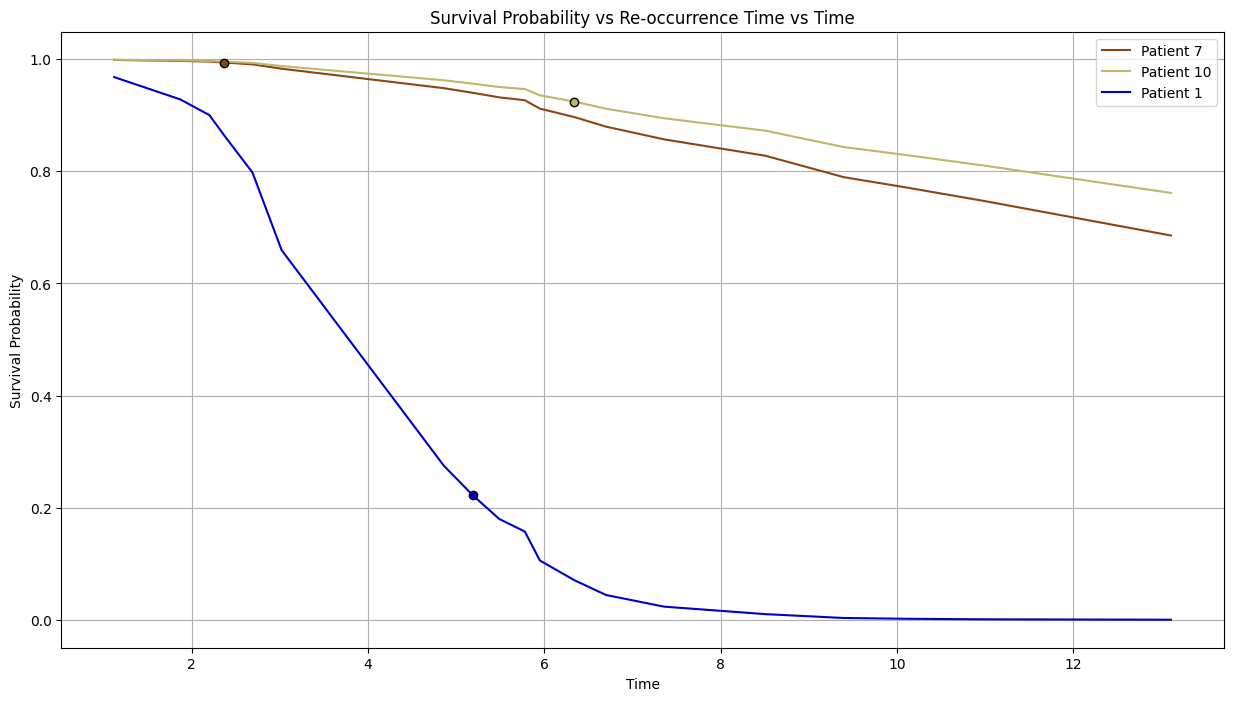

In [ ]:
# Visualization of 3 random Patients with DFS_STATUS_ENCODED = 1

# Get patient IDs and time intervals
patients_id = list(survival_probabilities_sorted.columns)
time_intervals = list(survival_probabilities_sorted.index)

# Filter test_data for patients with DFS_STATUS_ENCODED == 1
filtered_data = test_data[test_data['DFS_STATUS_ENCODED'] == 1]
# Ensure we have at least 3 patients; otherwise, select all available patients
num_patients_to_select = min(3, len(filtered_data))
selected_patients = random.sample(list(filtered_data.index), num_patients_to_select)


# Initialize color palette for selected patients
color_palatte = generate_random_colors(len(selected_patients))

# Get the time occurred values from the test data
time_occured = test_data["Disease Free (Months)"].to_list()

# Plotting
plt.figure(figsize=(15, 8))
for index, id in enumerate(selected_patients):
    plt.plot(time_intervals, survival_probabilities_sorted[id].to_list(),
             label=f"Patient {id}", color=color_palatte[index])
    # Plot dots on top of lines
    patient_index = patients_id.index(id)
    plt.scatter(x=time_occured[patient_index], y=generate_interpolation(id, patient_index, time_intervals),
                color=color_palatte[index],edgecolor='black',zorder=5)

plt.legend(loc="best")
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability vs Re-occurrence Time vs Time")
plt.show()